In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from exp.nb_03Magda import *
from exp.nb_04Magda import *

## get data

In [3]:
train_x, train_y, valid_x, valid_y, test_x, test_y = get_mnist()

In [4]:
norm = lambda x: normalize(train_x, x)
train_x, valid_x, test_x = [norm(x) for x in (train_x, valid_x, test_x)]

In [5]:
mnist_bunch = DataBunch(train_x, train_y, valid_x, valid_y, 5000)

### early stopping

In [6]:
#export
class Learner():
    def __init__(self, data_bunch, callback_list=None):
        self.data_bunch = data_bunch
        self._get_model()
        self._get_optimizer()
        self._loss_func()
        self.callback_list = callback_list
        self.epoch = 0
        self.batch_x = None
        self.batch_y = None
        self.metrics = {}

    def _get_model(self, num_hidden=50, num_out=10):
        num_in = self.data_bunch.train_data[:][0].size(1)
        self.model = nn.Sequential(nn.Linear(num_in, num_hidden), nn.ReLU(), nn.Linear(num_hidden, num_out))

    def _get_optimizer(self, lr=0.5):
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)

    def _loss_func(self):
        self.loss_func = F.cross_entropy

    def forward(self, bx, by):
        logits = self.model(bx)
        loss = self.loss_func(logits, by)
        return logits, loss

    def backward(self, loss):
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

    def fit(self, epochs):
        self.callback('fit_begin')
        for self.epoch in range(epochs):
            try:
                self.model.train()
                self.callback('train_begin')
                for (self.batch_x, self.batch_y) in self.data_bunch.train_dl:
                    logits, loss = self.forward(self.batch_x, self.batch_y)
                    self.backward(loss)
                    self.callback('train_batch_end', logits, loss)
                self.model.eval()
                with torch.no_grad():
                    self.callback('validation_begin')
                    for (self.batch_x, self.batch_y) in self.data_bunch.valid_dl:
                        logits, loss = self.forward(self.batch_x, self.batch_y)
                        self.callback('validation_batch_end', logits, loss)
                self.callback('epoch_end')
            except EarlyStopping:
                print(self.epoch, 'stopping ... ')
                break
        self.callback('fit_end')

    def callback(self, cb_name, *args, **kwargs):
        if self.callback_list:
            for cb in self.callback_list:
                cb_method = getattr(cb, cb_name, None)
                if cb_method:
                    cb.init_learner(self)
                    cb_method(*args, **kwargs)



Final accuracy: 0.935200


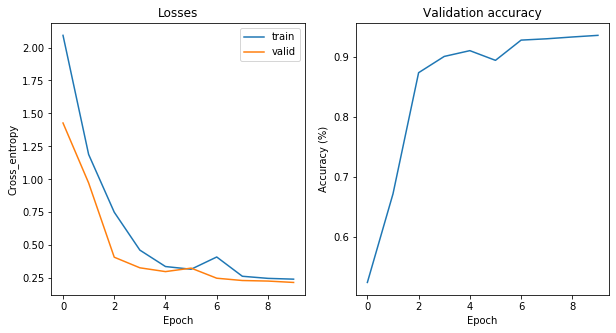

In [7]:
learner = Learner(mnist_bunch, [AccuracyCallback(), LossCallback(), PlotsCallback()])
learner.fit(10)    

In [8]:
#export
class EarlyStopping(Exception):
    pass

class EarlyStoppingCallback(Callback):
    def epoch_end(self):
        last_accuracy = self.learner.metrics.get('val_accuracies',[0])[-1]
        print(self.learner.epoch, 'last accuracy: ', last_accuracy)
        if last_accuracy > 0.9:
            raise EarlyStopping(f'Accuracy above 90\%, stopping after epoch {self.learner.epoch}.')
        

0 last accuracy:  0.6039000153541565
1 last accuracy:  0.8276000022888184
2 last accuracy:  0.8033999800682068
3 last accuracy:  0.8047000169754028
4 last accuracy:  0.8809000253677368
5 last accuracy:  0.8931000232696533
6 last accuracy:  0.9186999797821045
6 stopping ... 
Final accuracy: 0.918700


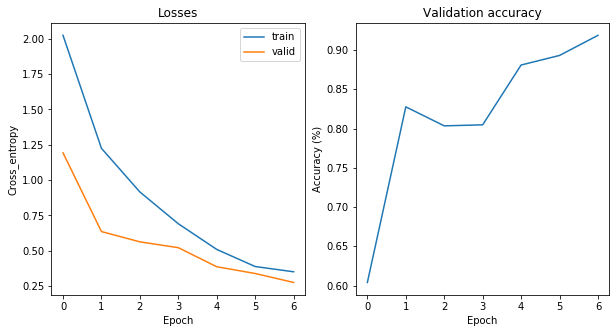

In [9]:
learner = Learner(mnist_bunch, [AccuracyCallback(), LossCallback(), PlotsCallback(), EarlyStoppingCallback()])
learner.fit(10)   

In [10]:
!python notebook2script.py 05Magda_early_stopping.ipynb

Converted 05Magda_early_stopping.ipynb to exp/nb_05Magda.py
